# Pitch Classifier

Data inspiration from Mike Fast's paper, ["What the Heck is PITCHf/x?"](http://baseball.physics.illinois.edu/FastPFXGuide.pdf).
Data from [Brooks Baseball](http://www.brooksbaseball.net/).

In [1]:
COLORS = {
    'FF': 'red',
    'SL': 'green',
    'FS': 'blue',
    'CH': 'orange',
    'CU': 'grey',
    'SI': 'purple',
    'FT': 'brown',
}

In [2]:
PITCH_TYPE_LABELS = {
    'FA': 'fastball',
    'FF': 'four-seam fastball',
    'FT': 'two-seam fastball',
    'FC': 'cutter',
    'FS': 'fastball',
    'SI': 'sinker',
    'FS': 'split-fingered fastball',
    'SL': 'slider',
    'CH': 'changeup',
    'CB': 'curveball',
    'CU': 'curveball',
    'KC': 'knuckle-curve',
    'KN': 'knuckleball',
    'EP': 'eephus',
    'UN': 'unidentified',
    'XX': 'unidentified',
    'PO': 'pitch out',
    'FO': 'pitch out',
}

## Load the Data

In [3]:
import pandas as pd

In [44]:
pitches = pd.read_csv('data/2019-06-17_547888_Tanaka.csv')

In [45]:
pitches.head()

,start_speed,pfx_x,pfx_z,mlbam_pitch_name
0,91.87,-4.517746,9.332202,FF
1,83.05,1.624604,1.942790,SL
2,91.21,-7.260078,7.255023,FF
3,81.80,4.409871,0.787128,SL
4,80.63,5.149924,2.596144,SL


In [46]:
pitches.columns

Index(['start_speed', 'pfx_x', 'pfx_z', 'mlbam_pitch_name'], dtype='object')

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
import numpy as np

In [49]:
pitch_types = pitches['mlbam_pitch_name'].unique()
pitch_types

array(['FF', 'SL', 'FS', 'CH', 'CU', 'SI', 'FT'], dtype=object)

In [50]:
colors = [ COLORS.get(pitch_type, 'black') for pitch_type in pitches['mlbam_pitch_name']]

Text(0, 0.5, 'pitch speed (mph)')

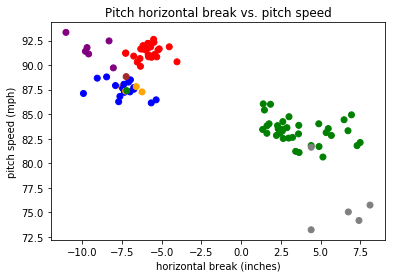

In [57]:
plt.scatter(pitches['pfx_x'], pitches['start_speed'], c=colors)
plt.title('Pitch horizontal break vs. pitch speed')
plt.xlabel('horizontal break (inches)')
plt.ylabel('pitch speed (mph)')

Text(0, 0.5, 'vertical break (inches)')

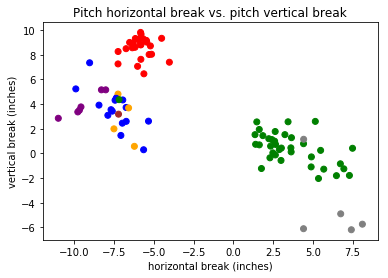

In [58]:
plt.scatter(pitches['pfx_x'], pitches['pfx_z'], c=colors)
plt.title('Pitch horizontal break vs. pitch vertical break')
plt.xlabel('horizontal break (inches)')
plt.ylabel('vertical break (inches)')

## Normalize the Data

In [13]:
cols_to_norm = ['start_speed', 'pfx_x', 'pfx_z']

In [14]:
pitches[cols_to_norm] = pitches[cols_to_norm].apply(lambda x: (x-x.min()) / (x.max() - x.min()))

In [15]:
pitches['pitch_type'] = pitches['mlbam_pitch_name'].apply(lambda type_code: int(np.where(pitch_types == type_code)[0]))

In [16]:
pitches

,start_speed,pfx_x,pfx_z,mlbam_pitch_name,pitch_type
0,0.926975,0.339739,0.970198,FF,0
1,0.488823,0.660851,0.508245,SL,1
2,0.894188,0.196375,0.840342,FF,0
3,0.426726,0.806460,0.435998,SL,1
4,0.368604,0.845149,0.549089,SL,1
5,0.500248,0.705539,0.389609,SL,1
6,0.391456,0.766764,0.466536,SL,1
7,0.397417,0.755568,0.547089,SL,1
8,0.711873,0.223302,0.549351,FS,2
9,0.442126,0.967574,0.412910,SL,1


In [17]:
import tensorflow as tf

In [18]:
start_speed = tf.feature_column.numeric_column('start_speed')
pfx_x = tf.feature_column.numeric_column('pfx_x')
pfx_z = tf.feature_column.numeric_column('pfx_z')

In [19]:
feat_cols = [start_speed, pfx_x, pfx_z]

## Train Test Split

In [20]:
pitches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 5 columns):
start_speed         95 non-null float64
pfx_x               95 non-null float64
pfx_z               95 non-null float64
mlbam_pitch_name    95 non-null object
pitch_type          95 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.8+ KB


In [21]:
x_data = pitches.drop(['mlbam_pitch_name','pitch_type'], axis=1)
x_data.head()

,start_speed,pfx_x,pfx_z
0,0.926975,0.339739,0.970198
1,0.488823,0.660851,0.508245
2,0.894188,0.196375,0.840342
3,0.426726,0.806460,0.435998
4,0.368604,0.845149,0.549089


In [22]:
labels = pitches['pitch_type']

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x_data, labels, test_size=0.33, random_state=101)

## Input Function

In [25]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train, batch_size=10, num_epochs=1000, shuffle=True)

In [26]:
model = tf.estimator.LinearClassifier(feature_columns=feat_cols, n_classes=len(pitch_types))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_model_dir': '/var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpkodl8vs9', '_session_config': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_tf_random_seed': 1}


In [27]:
model.train(input_fn=input_func, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpkodl8vs9/model.ckpt.
INFO:tensorflow:step = 1, loss = 19.4591
INFO:tensorflow:global_step/sec: 267.546
INFO:tensorflow:step = 101, loss = 8.504444 (0.380 sec)
INFO:tensorflow:global_step/sec: 402.733
INFO:tensorflow:step = 201, loss = 4.23999 (0.244 sec)
INFO:tensorflow:global_step/sec: 535.576
INFO:tensorflow:step = 301, loss = 5.6064367 (0.186 sec)
INFO:tensorflow:global_step/sec: 515.991
INFO:tensorflow:step = 401, loss = 11.780153 (0.193 sec)
INFO:tensorflow:global_step/sec: 485.274
INFO:tensorflow:step = 501, loss = 6.131202 (0.206 sec)
INFO:tensorflow:global_step/sec: 585.94
INFO:tensorflow:step = 601, loss = 7.6014614 (0.171 sec)
INFO:tensorflow:global_step/sec: 582.768
INFO:tensorflow:step = 701, loss = 5.0821986 (0.176 sec)
INFO:tensorflow:global_step/sec: 273.105
INFO:tensorflow:step = 801, loss = 11.709531 (0.364 sec)
INFO:tensorflow:g

## Evaluation

In [28]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(
    x=X_test,
    y=y_test,
    batch_size=10,
    num_epochs=1,
    shuffle=False
)

In [29]:
results = model.evaluate(eval_input_func)

INFO:tensorflow:Starting evaluation at 2019-06-30-22:43:15
INFO:tensorflow:Restoring parameters from /var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpkodl8vs9/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2019-06-30-22:43:16
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.75, average_loss = 0.9752206, global_step = 1000, loss = 7.801765


In [30]:
results

{'accuracy': 0.75,
 'average_loss': 0.9752206,
 'global_step': 1000,
 'loss': 7.801765}

# Predictions

In [31]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(
    x=X_test,
    batch_size=10,
    num_epochs=1,
    shuffle=False
)

In [32]:
p = model.predict(pred_input_func)

In [33]:
predictions = list(p)

INFO:tensorflow:Restoring parameters from /var/folders/kb/s3s7jjy90yx_6r9ztgl83y_m0000gp/T/tmpkodl8vs9/model.ckpt-1000


In [34]:
probabilities = [ [ round(i, 2) for i in pred['probabilities'] ] for pred in predictions ]
probabilities

[[0.73, 0.01, 0.16, 0.01, 0.0, 0.08, 0.01],
 [0.03, 0.91, 0.02, 0.01, 0.02, 0.0, 0.01],
 [0.2, 0.01, 0.36, 0.01, 0.0, 0.39, 0.02],
 [0.29, 0.05, 0.41, 0.03, 0.0, 0.19, 0.03],
 [0.74, 0.02, 0.15, 0.01, 0.0, 0.07, 0.01],
 [0.71, 0.02, 0.17, 0.01, 0.0, 0.07, 0.01],
 [0.72, 0.03, 0.16, 0.01, 0.0, 0.07, 0.01],
 [0.39, 0.05, 0.36, 0.03, 0.0, 0.14, 0.03],
 [0.06, 0.83, 0.05, 0.01, 0.02, 0.01, 0.01],
 [0.37, 0.06, 0.37, 0.03, 0.0, 0.15, 0.03],
 [0.18, 0.2, 0.4, 0.04, 0.01, 0.12, 0.04],
 [0.2, 0.14, 0.42, 0.04, 0.0, 0.15, 0.04],
 [0.04, 0.89, 0.03, 0.01, 0.02, 0.0, 0.01],
 [0.02, 0.93, 0.01, 0.01, 0.02, 0.0, 0.0],
 [0.09, 0.79, 0.07, 0.02, 0.01, 0.01, 0.01],
 [0.08, 0.81, 0.06, 0.01, 0.02, 0.01, 0.01],
 [0.0, 0.9, 0.0, 0.0, 0.1, 0.0, 0.0],
 [0.03, 0.87, 0.04, 0.01, 0.03, 0.0, 0.01],
 [0.0, 0.89, 0.0, 0.0, 0.11, 0.0, 0.0],
 [0.64, 0.01, 0.21, 0.01, 0.0, 0.11, 0.02],
 [0.58, 0.02, 0.24, 0.02, 0.0, 0.13, 0.02],
 [0.24, 0.07, 0.43, 0.03, 0.0, 0.19, 0.04],
 [0.01, 0.94, 0.01, 0.0, 0.02, 0.0, 0.0],
 

In [35]:
predicted_types = [ i.index(max(i)) for i in probabilities ]
predicted_types

[0,
 1,
 5,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 1]

In [36]:
[ PITCH_TYPE_LABELS[pitch_types[i]] for i in predicted_types ]

['four-seam fastball',
 'slider',
 'sinker',
 'split-fingered fastball',
 'four-seam fastball',
 'four-seam fastball',
 'four-seam fastball',
 'four-seam fastball',
 'slider',
 'four-seam fastball',
 'split-fingered fastball',
 'split-fingered fastball',
 'slider',
 'slider',
 'slider',
 'slider',
 'slider',
 'slider',
 'slider',
 'four-seam fastball',
 'four-seam fastball',
 'split-fingered fastball',
 'slider',
 'slider',
 'slider',
 'slider',
 'slider',
 'split-fingered fastball',
 'slider',
 'slider',
 'four-seam fastball',
 'slider']